# Exploratory Data Analysis

Univariate and bi- or multi-variate analysis of our cleaned data.

## Table of Contents

* [Importing libraries](#Importing-libraries)
* [Import the dataset](#Import-the-dataset)
* [Univariate analyses](#Univariate-analyses)
* [Bivariate and Multivariate Analyses](#Bivariate-and-Multivariate-Analyses)
* [Mapping points](#Mapping-points)
* [Conclusion of our EDA.](#Conclusion-of-our-EDA.)

## Importing libraries

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

## Import the dataset

Let's import our cleaned (but not one-hotted) dataset. The one-hotting will be useful for more complex algorithms later on.

In [2]:
#converter so that we read as list object and not string
from ast import literal_eval
dataset = pd.read_csv('../Data/cleaned_data.csv', converters={"cuisine_cats": literal_eval})
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833 entries, 0 to 2832
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            2833 non-null   int64  
 1   name          2833 non-null   object 
 2   rating        2833 non-null   float64
 3   latitude      2833 non-null   float64
 4   longitude     2833 non-null   float64
 5   price         2833 non-null   float64
 6   cuisine_cats  2833 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 155.1+ KB


In [3]:
dataset.head(2)

id            name  rating  latitude   longitude  price cuisine_cats
0   0           1-V:U     3.5  1.252299  103.820211   40.5          [0]
1   1  10 At Claymore     4.0  1.307401  103.829904   65.5          [1]

`id` is just a unique identifier we have for convenience purposes. `name` is the name of each restaurant. `rating` is the average rating users gave a restaurant. `latitude` and `longitude` are the GPS coordinates of the restaurant. `price` is the middle value of the price range we scraped.

`cuisine_cats` has the most interesting data-type; it is a list of indices into a separate list of cuisines. Let's import this cuisines list.

In [4]:
cuisines = pd.read_csv('../Data/cuisines.csv')
cuisines.describe()

0
count              52
unique             52
top     Asian Variety
freq                1

We already know some stuff about `cuisine_cats` from our data cleaning, which I will reproduce here.

In [5]:
print("Cuisines: {}".format(len(cuisines)))
print("The most cuisines in a restaurant: {}".format(dataset['cuisine_cats'].apply(len).max()))

Cuisines: 52
The most cuisines in a restaurant: 6


## Univariate analyses

Let's look at each of our variables.

### Univariate analysis of `rating`

We'll start by looking at our summary statistics. Rating is in the form of discrete categories; however, there isa clear numerical ordering, and thus we can to an extent treat it as numerical data.

In [6]:
dataset['rating'].describe()

count    2833.000000
mean        3.623014
std         0.311548
min         2.000000
25%         3.500000
50%         3.500000
75%         4.000000
max         5.000000
Name: rating, dtype: float64

Mean rating is a 3.6, with a standard deviation of 0.31. That means that at least 68% of our restaurants will fall in the 3.0-4.0 rating range. There is no restaurant with a rating below 2.0. The maximum rating is 5.0. The median rating is 3.5. The 25th percentile rating is also 3.5; the 75th percentile is 4.0. At least 50% of our restaurants are thus in the 3.5-4.0 rating range. Let's try looking at a boxplot.

<AxesSubplot:>

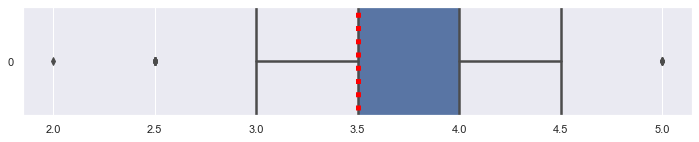

In [7]:
plt.figure(figsize=(12,2))
sb.boxplot(data=dataset['rating'], orient="h", linewidth=2.5, width=16, medianprops={'color': 'red', 'ls': ':', 'lw': 5})

Our boxplot again shows our median to coincide with the 25th percentile. We also know it to be left of the mean, which is 3.6; we are thus seeing a heavy positive skew.  Furthermore, our boxplot's 1.5 IQR whiskers extend from 3.0 to 4.5; it thus seems to be the case that ratings of 2.0, 2.5 and 5.0 are outliers.

Let's try investigating our data further with a histogram of ratings.

<AxesSubplot:xlabel='rating', ylabel='Count'>

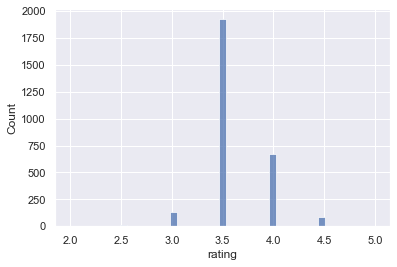

In [8]:
sb.histplot(data=dataset['rating'])

This confirms our understanding that the vast majority of ratings are in the 3.0-4.5 range, and that our distribution is a discrete approximation of a positively skewed normal distribution. A KDE or violin plot would be inappropriate due to the discrete nature of our ratings data, as it would show us a false smoothness. We are thus left with the last thing of interest, which is to find out how the exact percentiles of all our rating values.

In [9]:
from scipy import stats
for i in [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
    print("Percentile <= {} is {:.2f}, > is {:.2f}"
          .format(i,
                  below:=stats.percentileofscore(dataset['rating'],i, kind='weak'),
                  100-below))

Percentile <= 2.0 is 0.04, > is 99.96
Percentile <= 2.5 is 0.60, > is 99.40
Percentile <= 3.0 is 5.15, > is 94.85
Percentile <= 3.5 is 73.07, > is 26.93
Percentile <= 4.0 is 96.75, > is 3.25
Percentile <= 4.5 is 99.79, > is 0.21
Percentile <= 5.0 is 100.00, > is 0.00


0.04% percent of our data is 2.0 or lower. 0.60% of our data is 2.5 or lower. 5.15% of our data is 3.0 or lower. We can thus say that low ratings in the 2.0-3.0 range are exceedingly rare, and restaurants have to be either really terrible or really unlucky to get them.

26.93% of restaurants score 4.0 or higher. 3.25% of restaurants score 4.5 or higher. Only 0.21% of restaurants score a perfect 5.0. We can thus conclude that very high ratings of 4.5-5.0 are likewise very rare.

### Univariate analysis of `price`.

In [10]:
dataset['price'].describe()

count    2833.000000
mean       20.138193
std        30.098849
min         4.500000
25%         4.500000
50%        15.500000
75%        25.500000
max       400.500000
Name: price, dtype: float64

Looks like our standard deviation is really big, in fact larger than the mean. The mean is also larger than the standard deviation, and the max is far larger than the median. This implies our distribution has a long tail extending far to the left, and is thus strongly positively skewed.

<AxesSubplot:>

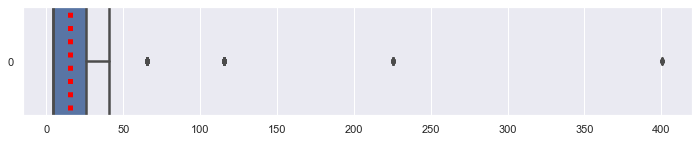

In [11]:
plt.figure(figsize=(12,2))
sb.boxplot(data=dataset['price'], orient="h", linewidth=2.5, width=16, medianprops={'color': 'red', 'ls': ':', 'lw': 5})

The box plot confirms it; we have clumps of values far to the right of the median, in fact to the right of the whiskers too (implying they are outliers).

<AxesSubplot:xlabel='price', ylabel='Count'>

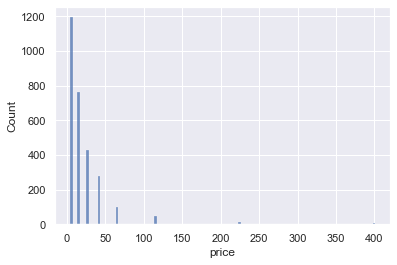

In [12]:
sb.histplot(data=dataset['price'])

Our histogram clearly shows very strong positive skew. In fact, our distribution appears to not be a normal distribution; it is rather a "shifted exponential" distribution, as illustrated by the chart below. Note how there are no values to the left of the modal class.

<img src="https://i.redd.it/ebs7blwt66m41.jpg" alt="types of distributions" width="400" align='left'/>

### Univariate analysis of `latitude`.

In [13]:
dataset['latitude'].describe()

count    2833.000000
mean        1.317245
std         0.036561
min         1.243262
25%         1.292364
50%         1.305143
75%         1.337066
max         1.466940
Name: latitude, dtype: float64

Looks like our standard deviation and min-max range are numerically really small compared to our mean. That makes sense; these are GPS coordinates which give absolute positions on the surface of the Earth, and all of ours are local in a single city (Singapore). It does mean we will need to normalise it to do much with it, though.

<AxesSubplot:>

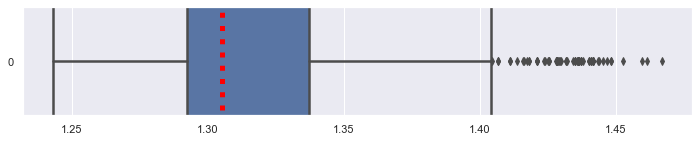

In [14]:
plt.figure(figsize=(12,2))
sb.boxplot(data=dataset['latitude'], orient="h", linewidth=2.5, width=16, medianprops={'color': 'red', 'ls': ':', 'lw': 5})

Looks like we've got positive skew, with median (1.305N) significantly towards the left of the box. This seems to correspond with Singapore having a high density of restaurants and other businesses in the south, with a slow taper as you go north.

There are also a lot of outlier values clustered to the far north, past 1.40N latitude.

<AxesSubplot:>

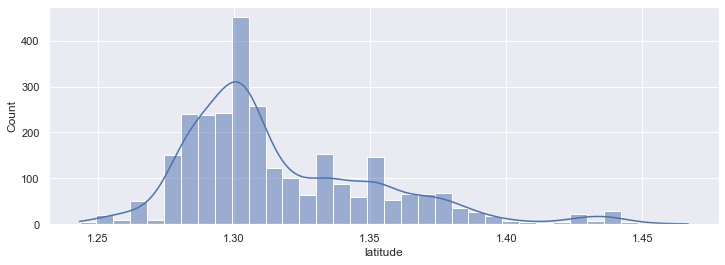

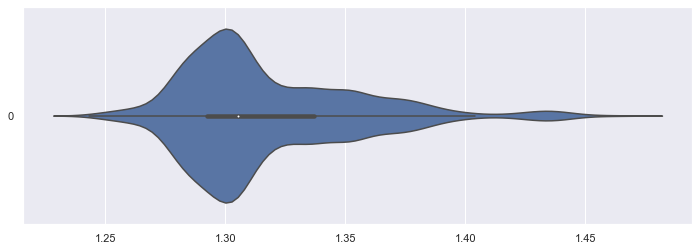

In [15]:
fig, ax = plt.subplots(figsize=(12,4))
sb.histplot(data=dataset['latitude'], kde=True, ax=ax)
fig, ax = plt.subplots(figsize=(12,4))
sb.violinplot(data=dataset['latitude'], orient="h", ax=ax)

Our histogram/KDE and violin plots confirm that our latitude data is roughly normal, but with abnormalities somewhat to the right of the peak which make it rather positively skewed and give it a minor second peak far to the left, in latitude 1.40-1.45, corresponding with the cluster of northern outliers we previously saw. Later on we will more clearly see what could cause this through a geographic visualisation.

### Univariate analysis of `longitude`.

In [16]:
dataset['longitude'].describe()

count    2833.000000
mean      103.843154
std         0.051567
min       103.679230
25%       103.828089
50%       103.844895
75%       103.856858
max       103.990648
Name: longitude, dtype: float64

Looks like our standard deviation and min-max range are numerically really small compared to our mean. That makes sense; these are GPS coordinates which give absolute positions on the surface of the Earth, and all of ours are local in a single city (Singapore). It does mean we will need to normalise it to do much with it, though.

<AxesSubplot:>

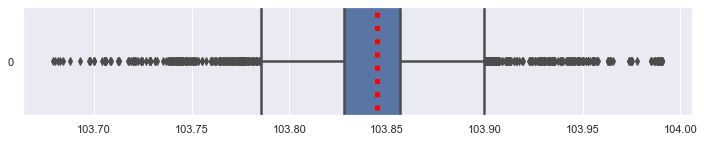

In [17]:
plt.figure(figsize=(12,2))
sb.boxplot(data=dataset['longitude'], orient="h", linewidth=2.5, width=16, medianprops={'color': 'red', 'ls': ':', 'lw': 5})

Looks like we've got slight negative skew, with median (103.844E) somewhat towards the right of the box.

We also seem to have a lot of outliers past the whiskers, this time to both the east and the west of our median.

<AxesSubplot:>

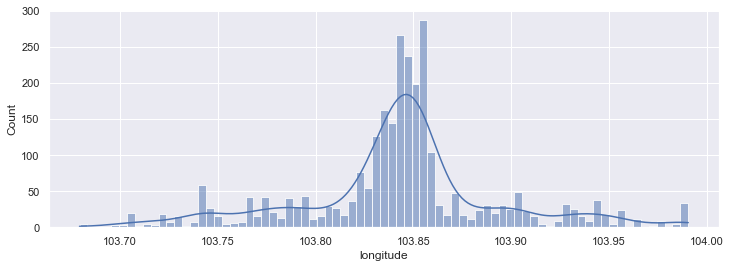

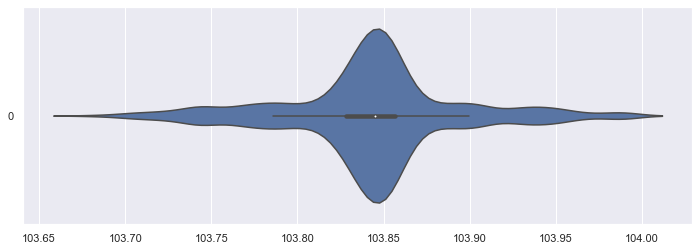

In [18]:
fig, ax = plt.subplots(figsize=(12,4))
sb.histplot(data=dataset['longitude'], kde=True, ax=ax)
fig, ax = plt.subplots(figsize=(12,4))
sb.violinplot(data=dataset['longitude'], orient="h", ax=ax)

Our histogram/KDE and violin plots confirm that our latitude data is roughly a normal distribution with slight skew. However, the tail on both the left and the right tapers slowly and is rather thick, with many outlier values. Let's actually count our outliers.

In [19]:
df = dataset['longitude']
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print("{} outliers to the left/west, {} to the right/east\n"\
      "{} outliers in total, out of {} data points\n"\
      "{:.1f}% of our data points are outliers wrt longitude"
      .format(left := (df < (Q1 - 1.5 * IQR)).sum(),
              right := (df > (Q3 + 1.5 * IQR)).sum(),
              total := left+right,
              lendf := len(df), 100 * total/lendf))

347 outliers to the left/west, 340 to the right/east
687 outliers in total, out of 2833 data points
24.2% of our data points are outliers wrt longitude


24.2% of our data points are outliers by the 1.5\*IQR metric, roughly equally split between outliers to the left and outliers to the right of the media. That's quite a lot and indicates that longitude-wise restaurants are pretty smoothly distributed throughout Singapore, with a peak in the middle.

### Univariate analysis of `cuisine_cats`

This will be interesting and challenging, due to the data type (lists of cuisines) and it being categorical data with a high number of categories.

We will start by looking at the distribution of our data points across our 52 cuisines; we will count a data point as belonging to a cuisine if that cuisine is one the cuisines listed in it. For this we will import our one-hotted data, as that will make it easier.

In [20]:
onehotted = pd.read_csv("../Data/cleaned_onehotted.csv", converters={"cuisine_cats": literal_eval})
onehotted.head(2)

id            name  rating  latitude   longitude  price cuisine_cats  \
0   0           1-V:U     3.5  1.252299  103.820211   40.5          [0]   
1   1  10 At Claymore     4.0  1.307401  103.829904   65.5          [1]   

   mult_cuisines  Asian Variety  Multi-Cuisine  ...  Western Variety  \
0              0              1              0  ...                0   
1              0              0              1  ...                0   

   Vietnamese  Beijing  Russian  Foochow  Hakka  Caribbean  Filipino  Irish  \
0           0        0        0        0      0          0         0      0   
1           0        0        0        0      0          0         0      0   

   Dong Bei  
0         0  
1         0  

[2 rows x 60 columns]

In [21]:
cuisine_cols = onehotted.iloc[:, 8:]
cuisine_cols.head(2)

Asian Variety  Multi-Cuisine  Korean  Belgian  Singaporean  Chinese  \
0              1              0       0        0            0        0   
1              0              1       0        0            0        0   

   Cantonese  Hong Kong  Teochew  Malay  ...  Western Variety  Vietnamese  \
0          0          0        0      0  ...                0           0   
1          0          0        0      0  ...                0           0   

   Beijing  Russian  Foochow  Hakka  Caribbean  Filipino  Irish  Dong Bei  
0        0        0        0      0          0         0      0         0  
1        0        0        0      0          0         0      0         0  

[2 rows x 52 columns]

In [22]:
cuisine_sums = pd.DataFrame(cuisine_cols.sum()).reset_index().set_axis(['name', 'sum'], axis=1)
cuisine_sums.head()

name  sum
0  Asian Variety   30
1  Multi-Cuisine  112
2         Korean  121
3        Belgian   12
4    Singaporean  313

<AxesSubplot:xlabel='name', ylabel='sum'>

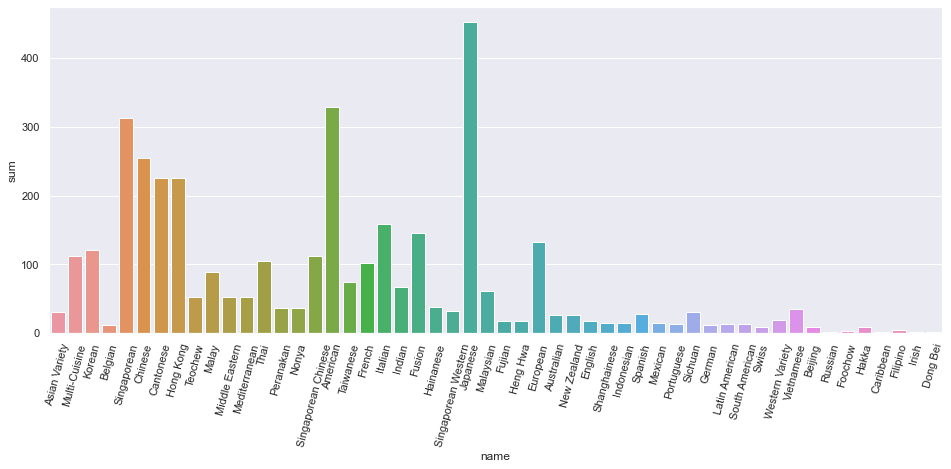

In [23]:
fig, ax = plt.subplots(figsize=(16,6))
plt.xticks(rotation=75)
sb.barplot(x=cuisine_sums['name'], y=cuisine_sums['sum'], ax=ax)

Looks like our cuisine data is not at all evenly distributed. There are a few really popular categories, a lot of moderately popular categories, and an equal amount of rare categories. The most popular are Japanese, American, Singaporean, Chinese, Cantonese and Hong Kong; the least popular are Russian, Foochow, Caribbean, Irish and Dong Bei, each of which only possess a handfull of restaurants.

Sometimes a restaurant has only one cuisine listed, sometimes there are multiple. The maximum is known from earlier in this notebook to be 6. There are 52 unique cuisines in total. 

We have "Multi-Cuisine" as one of the cuisine tags present in our original data. Let's look more closely at how many restaurants, single- and multi-cuisine, list this as a tag.

In [24]:
multi_multi = len(onehotted[(onehotted.mult_cuisines == 1) & (onehotted['Multi-Cuisine'] == 1)])
multi_not_multi = len(onehotted[(onehotted.mult_cuisines == 0) & (onehotted['Multi-Cuisine'] == 1)])
print("{} restaurants have \"Multi-Cuisine\" as the only cuisine listed.\n"\
      "{} restaurants have \"Multi-Cuisine\" as one of multiple tags."
      .format(multi_not_multi, multi_multi))

96 restaurants have "Multi-Cuisine" as the only cuisine listed.
16 restaurants have "Multi-Cuisine" as one of multiple tags.


The number of restaurants with "Multi-Cuisine" as the only cuisine listed (96 restaurants) is significant enough to need correction. Consequently, where it is the the only cuisine or one of two cuisines we'll treat multi-cuisine as the modal number of cuisines.

In [25]:
cuisine_nums = onehotted['cuisine_cats'].apply(lambda x: len(x))
print("The modal number of cuisines is {}.".format(cuisine_nums_mode := cuisine_nums.mode()[0]))

The modal number of cuisines is 1.


Time to take a closer look at the distribution of cuisines, correcting as described for "Multi-Cuisine".

<AxesSubplot:ylabel='Count'>

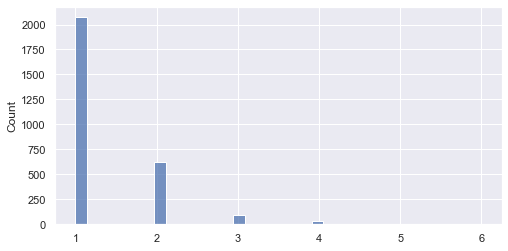

In [26]:
cuisine_nums_fixed = cuisine_nums + (((onehotted.mult_cuisines == 0) &
                                      (onehotted['Multi-Cuisine'] == 1))
                                     .apply(lambda x: x*(cuisine_nums_mode-1)))
fig, ax = plt.subplots(figsize=(8,4))
sb.histplot(cuisine_nums_fixed)

Looks like there are a lot of single-cuisine restaurants, some 2-cuisine and a few 3-cuisine restaurants, and then very few 4, 5 or 6 cuisine restaurants. Let's try seeing the exact percentiles, again correcting for "Multi-Cuisine".

In [27]:
from scipy import stats
for i in range(1,7):
    print("Percentile <= {} is {:.2f}, > is {:.2f}"
          .format(i,
                  below:=stats.percentileofscore(cuisine_nums_fixed,i, kind='weak'),
                  100-below))

Percentile <= 1 is 73.17, > is 26.83
Percentile <= 2 is 95.34, > is 4.66
Percentile <= 3 is 98.62, > is 1.38
Percentile <= 4 is 99.75, > is 0.25
Percentile <= 5 is 99.96, > is 0.04
Percentile <= 6 is 100.00, > is 0.00


73.17% of restaurants have one cuisine, and 95.34% of restaurants have 1 or 2 cuisinesa.

Just 1.38% have 3 or more cuisines, and only 0.04% have 6 cuisines.

Lastly, for each cuisine, what proportion of restaurants have it as the sole cuisine?

In [28]:
grouped_cols_no_mult = (onehotted.iloc[:, 7:]
                        .drop(onehotted[onehotted.mult_cuisines == 1].index)
                        .sum().iloc[1:].reset_index().set_axis(['name', 'sum'], axis=1))
grouped_cols_no_mult['multiple cuisines'] = False
grouped_cols_mult = (onehotted.iloc[:, 7:]
                     .drop(onehotted[onehotted.mult_cuisines == 0].index)
                     .sum().iloc[1:].reset_index().set_axis(['name', 'sum'], axis=1))
grouped_cols_mult['multiple cuisines'] = True
grouped_cols = pd.concat([grouped_cols_no_mult, grouped_cols_mult])
grouped_cols.head()

name  sum  multiple cuisines
0  Asian Variety    9              False
1  Multi-Cuisine   96              False
2         Korean  112              False
3        Belgian   11              False
4    Singaporean  119              False

<AxesSubplot:xlabel='name', ylabel='sum'>

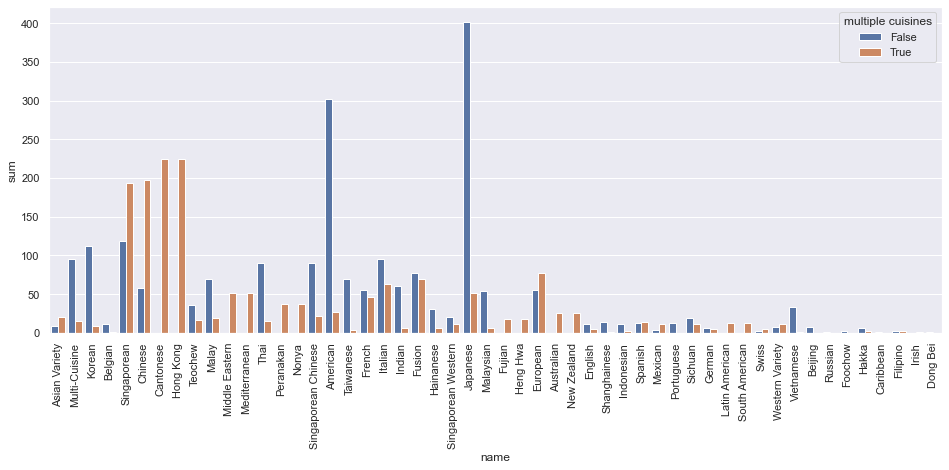

In [29]:
fig, ax = plt.subplots(figsize=(16,6))
plt.xticks(rotation=90)
sb.barplot(x='name', y='sum', hue='multiple cuisines', data=grouped_cols, ax=ax)

This is quite interesting. In line with 73.17% of restaurants having only one cuisine, it looks like most cuisines are found usually as a restaurant's only cuisines. Singaporean, Chinese, Cantonese, Hong Kong, and European buck the trend; Cantonese and Hong Kong are especially interesting, as they're almost always found as one of multiple cuisines a restaurant is tagged with.

Since Cantonese and Hong Kong are among the most popular cuisines, and usually found with other cuisines in a restaurant's tags, let's have a look at the other cuisines they are most frequently paired with.

First we will look at Cantonese.

<AxesSubplot:xlabel='name', ylabel='sum'>

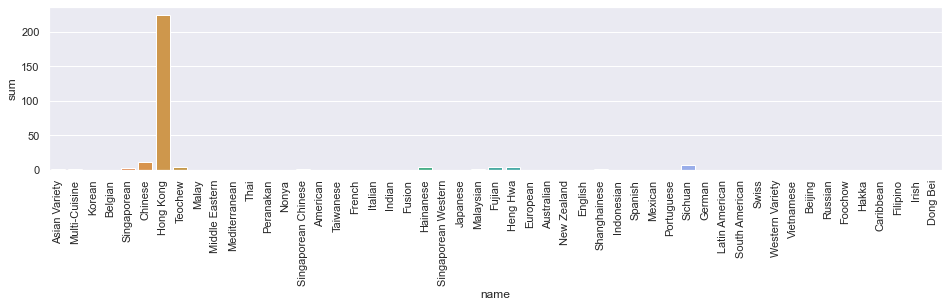

In [30]:
can_cuisine_sums = (pd.DataFrame(cuisine_cols
                                 .drop(cuisine_cols[cuisine_cols.Cantonese != 1].index)
                                 .sum())
                    .reset_index().set_axis(['name', 'sum'], axis=1)
)
can_cuisine_sums = can_cuisine_sums[(can_cuisine_sums.name != 'Cantonese')]
fig, ax = plt.subplots(figsize=(16, 3))
plt.xticks(rotation=90)
sb.barplot(x='name', y='sum', data=can_cuisine_sums, ax=ax)

<AxesSubplot:xlabel='name', ylabel='sum'>

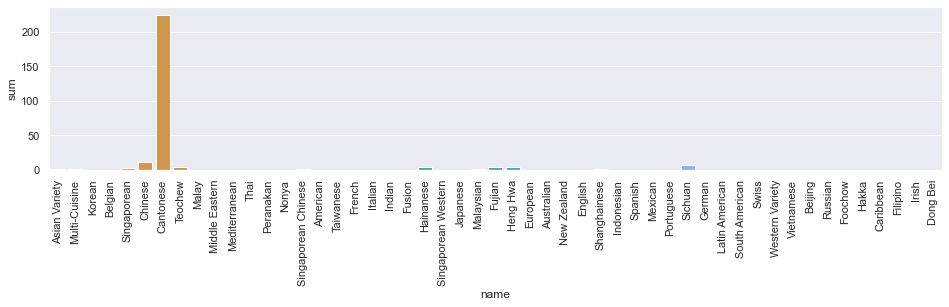

In [31]:
hk_cuisine_sums = (pd.DataFrame(cuisine_cols
                                .drop(cuisine_cols[cuisine_cols.Cantonese != 1].index)
                                .sum())
                   .reset_index().set_axis(['name', 'sum'], axis=1)
)
hk_cuisine_sums = hk_cuisine_sums[(hk_cuisine_sums.name != 'Hong Kong')]
fig, ax = plt.subplots(figsize=(16, 3))
plt.xticks(rotation=90)
sb.barplot(x='name', y='sum', data=hk_cuisine_sums, ax=ax)

Turns out Hong Kong and Cantonese are almost always paired with each other. Our univariate analyses are now complete. We'll move on to trying to find correlations/patterns through bivariate and multivariate analysis.

## Bivariate and Multivariate Analyses

Let's look at two or more of our variables at a time.

We will min-max scale latitude and longitude first, as they have very compressed range and standard deviation.

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(dataset[['latitude', 'longitude']])
dataset[['latitude', 'longitude']] = scaler.transform(dataset[['latitude', 'longitude']])

### Correlations between numeric variables

<AxesSubplot:>

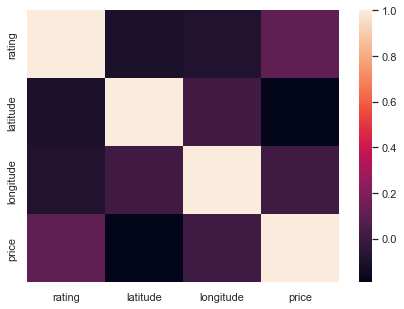

In [33]:
bi_corr = dataset.iloc[:,1:].corr()
fig, ax = plt.subplots(figsize=(7, 5))
sb.heatmap(bi_corr, ax=ax)

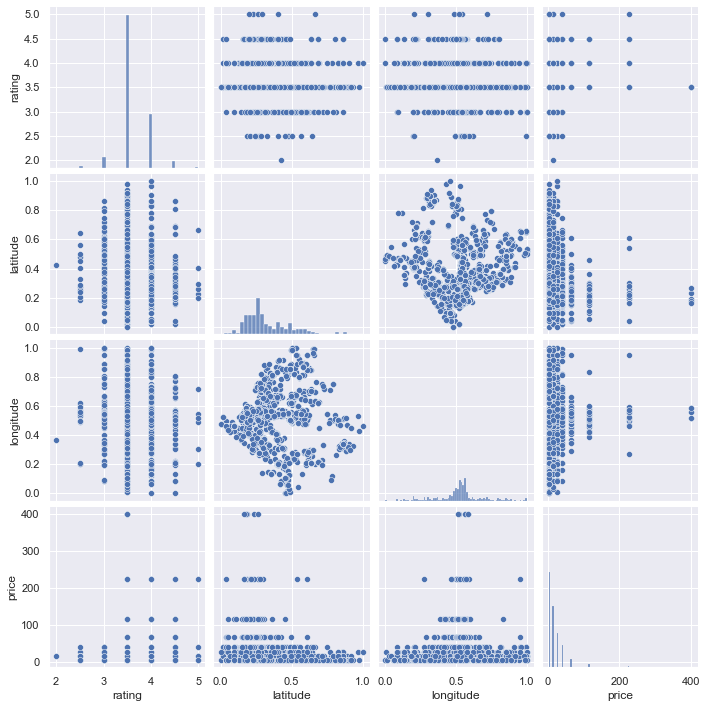

In [34]:
sb.pairplot(dataset.iloc[:,1:])

Looks like none of our numeric variables have much linear correlation with each other individually, as shown by our correlation heatmap and our pairplot.

As a multivariate analogue of correlation, we can take multiple independent variables and look at the R^2 value of a linear regression fit to them and a dependent variable. We will use a randomised train-test split.

<AxesSubplot:ylabel='predictor'>

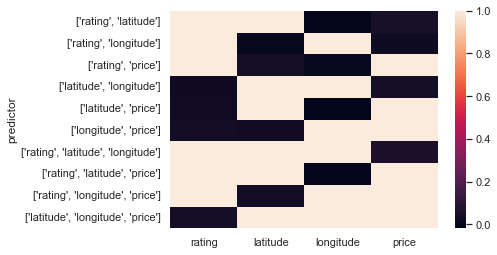

In [35]:
import itertools
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

variables = ['rating', 'latitude', 'longitude', 'price']

combinations = (list(itertools.combinations(variables, 2)) +
                list(itertools.combinations(variables, 3)))

df_to_be = []
for i in [list(k) for k in combinations]:
    r2_values = []
    
    for j in variables:
        regr = linear_model.LinearRegression()
        X_train, X_test, y_train, y_test = train_test_split(dataset[i], dataset[j],
                                                            test_size=0.2, random_state=42)
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)
        r2_values.append(r2_score(y_test, y_pred))
        
    df_to_be.append([i] + r2_values)
    
df = pd.DataFrame(df_to_be, columns=['predictor'] + variables)
df = df.set_index('predictor')
sb.heatmap(data=df)

Our multivariate linear regression also fails to attain a good R^2 value. Seems like we can't linearly predict our numeric variables using each other. 

### Distributions over cuisine.

Can we use our varied and unordered categorical variable, cuisine, to make inferences about the rest of our data?

We will use scatter plots and bar plots, with the bar plots showing mean and median of different cuisines.

#### Cuisine-Price Analysis

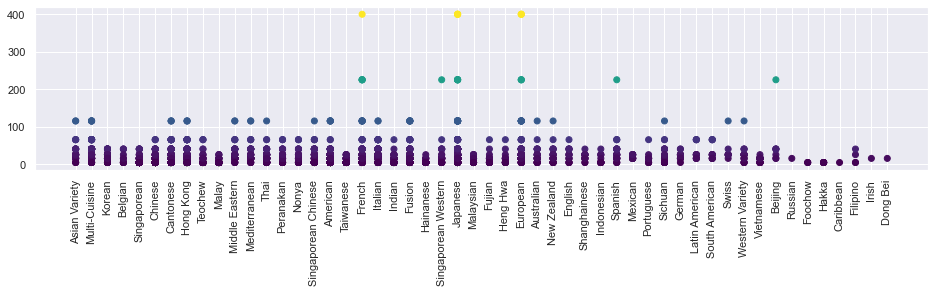

In [36]:
cuisines_list = list(cuisines.iloc[:,0])
dup_cuisine = dataset.explode('cuisine_cats')
dup_cuisine['cuisine'] = dup_cuisine['cuisine_cats'].apply(lambda x: cuisines_list[x])
dup_cuisine = dup_cuisine.drop('cuisine_cats', axis=1)

def cuisine_y_scatter(y):
    cuisines_list=list(cuisines.iloc[:,0])

    fig, ax = plt.subplots(figsize=(16, 3))
    plt.xticks(rotation=90)
    plt.scatter(data=dup_cuisine, x='cuisine', y=y, c=y, cmap='viridis')
cuisine_y_scatter('price')

Looks like the high-price restaurants are only present in a subset of cuisines.

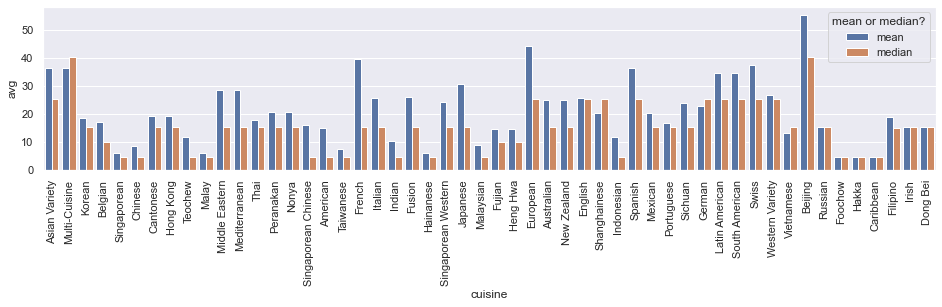

In [37]:
def cuisine_y_bar(y):
    #cuisine, avg, mean or median?
    df_to_be = []

    df = dup_cuisine
    
    for i in cuisines_list:
        matching_only = df[df['cuisine'] == i]
        df_to_be.append([i, matching_only[y].mean(), 'mean'])
        df_to_be.append([i, matching_only[y].median(), 'median'])

    df = pd.DataFrame(df_to_be, columns=['cuisine', 'avg', 'mean or median?'])
    fig, ax = plt.subplots(figsize=(16,3))
    plt.xticks(rotation=90)
    sb.barplot(data=df, x='cuisine', y='avg', hue='mean or median?', ax=ax)
cuisine_y_bar('price')

Looks like our mean and median price both vary a lot with cuisine!

#### Cuisine-Rating analysis.

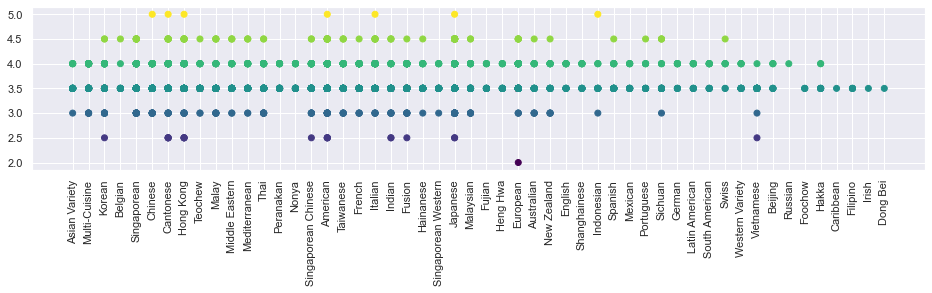

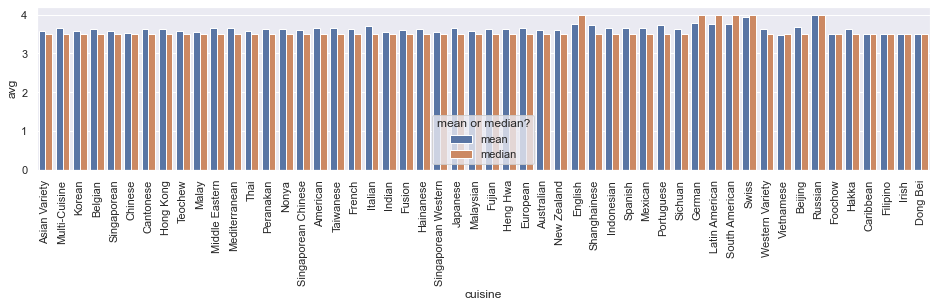

In [38]:
cuisine_y_scatter('rating')
cuisine_y_bar('rating')

Seems like our lowest rating, 2.0, only exists for European cuisines.  Only a few cuisines have restaurants of the highest rating, 5.

Besides that, it appears that the median and mean of ratings does not vary much at all with cuisine.

#### Cuisine-Latitude Analysis


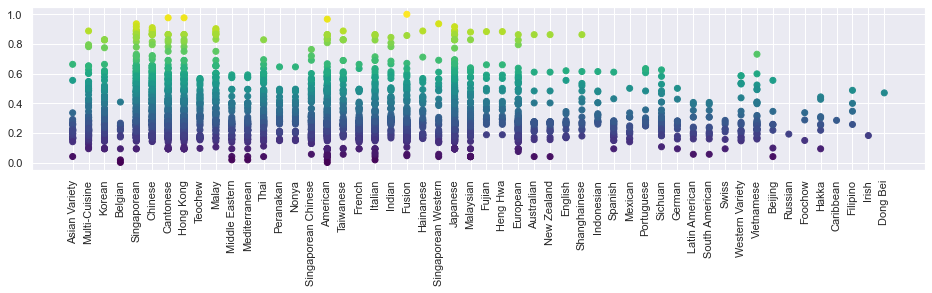

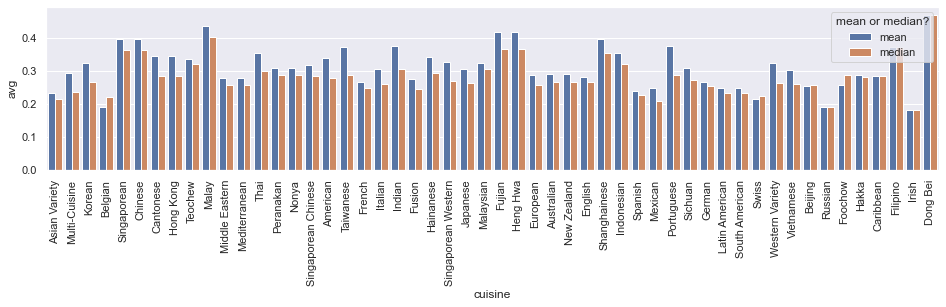

In [39]:
cuisine_y_scatter('latitude')
cuisine_y_bar('latitude')

Looks like both the distribution and central tendency of latitude vary significantly with cuisine.

#### Cuisine-Longitude Analysis

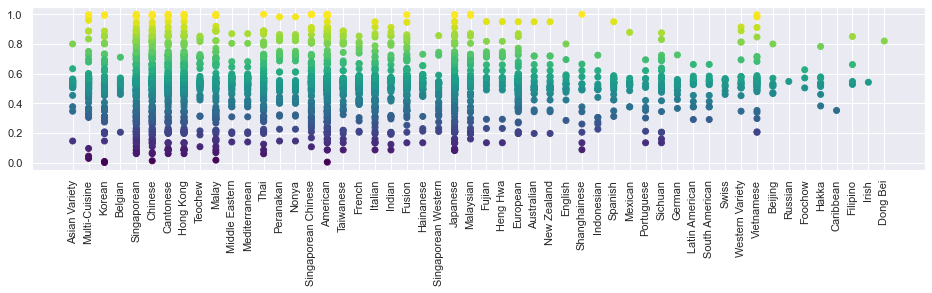

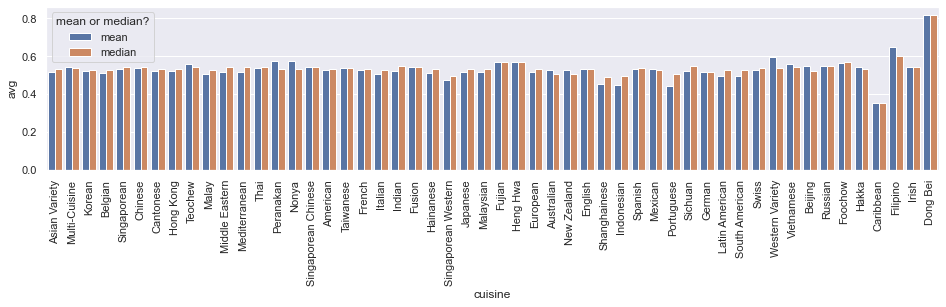

In [40]:
cuisine_y_scatter('longitude')
cuisine_y_bar('longitude')

From our scatter plot, we can see that the distribution of longititudes varies with the cuisine. The central tendency, however, does not vary much with the exception of Carribean and Dong Bei cuisine. Carribean has a significantly weswards bias, and Dong Bei eastwards. This is probably explained by the low number of restaurants in these two cuisines.

## Mapping points

As our last stage of EDA, let's try using latitude and longitude to plot points on a map of Singapore, and colour using price and rating. To aid in interpretation, we'll be selecting colours based on the percentile of the data's distribution a datapoint falls in, such that the difference in colour directly corresponds to the difference in percentile.

In [41]:
import geopandas as gpd
import matplotlib.colors as colors
dataset[['latitude', 'longitude']] = scaler.inverse_transform(dataset[['latitude', 'longitude']])

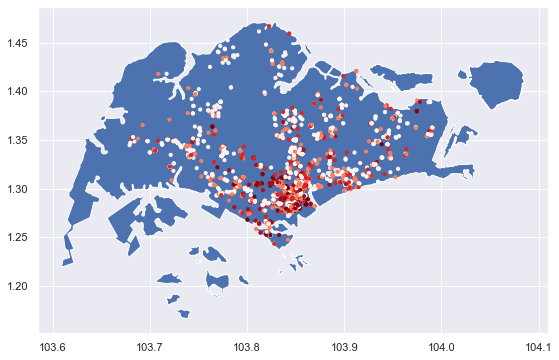

In [65]:
sgmap = gpd.read_file("../Data/SGP.json", driver='shapefile')
df = pd.DataFrame(dataset)

fig, ax = plt.subplots(figsize=(14,6))
sgmap.plot(ax=ax)
ax.scatter(data=dataset, x='longitude', y='latitude', s=10,
           c=df['price'].apply(lambda x: stats.percentileofscore(df['price'], x)), cmap='Reds')

It looks like our prices are not at all evenly distributed with regards to GPS coords.

The actual distribution is rather complex and consists of multiple clusters of various sizes.

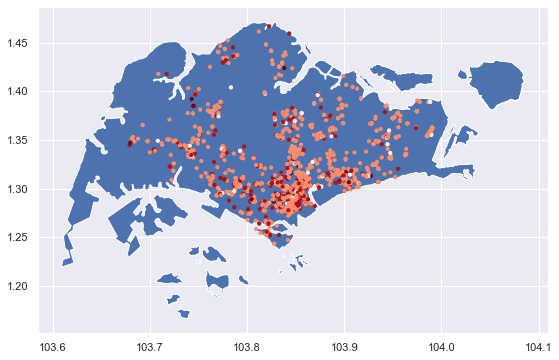

In [59]:
fig, ax = plt.subplots(figsize=(14,6))
sgmap.plot(ax=ax)
ax.scatter(data=dataset, x='longitude', y='latitude', s=10,
           c=df['rating'].apply(lambda x: stats.percentileofscore(df['rating'], x)), cmap='Reds')

Again, it looks like our ratings are unevenly distributed, with complex clustering.

### Conclusion of our EDA.

The values in our dataset, which are a mix of numeric and categorical, have widely varying distributions. There are no easy linear correlations to be found with our numeric variables, but there is often a lot of variance in their distributions with respect to our categorical variable of cuisine, and there appears to be nontrivial clustering when our price and ratings are plotted geographically, meaning against latitude and longitude.